In [109]:
# imports 
from empath import Empath
lexicon = Empath()

## Steps for feature analysis aka violence metric


1. Take advantage of Empath package to obtain categories representatives of violence
    - a. Produce clean data locally thanks to results 
    - b. Preprocess as did in the paper to train Empath to ensure alignment with features found 
    - c. Perform Empath.lexicon.analyse with word counts, sorted_list (gives out cosine similarity between the vector of the category and the vector of the text given (need to reread that in paper))

2. Identify the most represented categories in the plot per genre, per year
3. Identify the most represented categories per movies classified as violent per ChatGPT 
4. Balance the frequencies of the words per their weight //TFID-matrix 
5. Our own logistic regression model : stantardise/normalise the train, test data 
6. Transform our plots in bags of words 
7. Side quest: Perform clustering on bags of words (idea: does it appear by itself group of violent movies)
8. Visualisation of number of words per movies, per genres 
9. If skewed, try logarithm and see if it becomes gaussian -> fit with logarithm 
10. Our own model : have p-value
Idea : try to replicate chatgpt predictions and explain them 

In [110]:
# Manual selection of supposedly violent categories

violent_categories = ["hate", "aggression", "occupation", "crime", "prison", "dispute", "nervousness", "horror", 
              "swearing_terms", "suffering", "kill", "fear", "death", "violence", "dominant_heirarchical", 
              "neglect", "monster", "weapon", "negative_emotion", "pain", "terrorism", "breaking", 
              "disappointment", "anger", "torment", "shame", "emotional", "sadness",
              "rage", "injury", "fire", "disgust", "war", "dominant_personality",
              "fight", "deception"]

# If we want to manually inspect the categories
""" for category in categories: 
    print("Category =" + category, lexicon.cats.get(category)) """

' for category in categories: \n    print("Category =" + category, lexicon.cats.get(category)) '

### 0. Emma's playground (04.12.2024) starts here (clean)

In [111]:
# We import the clean dataset (& have a look at it again, just because it's beautiful)
import pandas as pd
Movie_Data = pd.read_csv('../data/CLEAN/Movie_Data_clean.tsv', sep="\t")
Movie_Data

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
0,975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
1,6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
2,77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
3,21926710,White on Rice,2009-05-31,NaN,NaN,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
4,156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,NaN,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
17074,1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...
17075,664006,Guilty as Sin,1993-06-04,22886222.0,NaN,United States of America,"Thriller, Erotic thriller, Psychological thril...",jennifer haines is an up-and-coming chicago a...


In [112]:
# Let's try this all with the first summary

Plot_test = Movie_Data.loc[0]["Plot"]

# Now, let's use spacy, to tokenize
import spacy

nlp = spacy.load('en_core_web_sm') # requires python spacy download en !
doc = nlp(Plot_test)
Plot_tokens = [token.text for token in doc]

print(Plot_test,'\n')
print(Plot_tokens)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [113]:
# Now let's detect the stopwords

spacy_stopwords = spacy.lang.en.stop_words.STOP_WORDS
print('Number of stop words: %d' % len(spacy_stopwords))
print('First ten stop words:',list(spacy_stopwords)[:10])

Number of stop words: 326
First ten stop words: ['our', 'it', 'therefore', 'back', 'beforehand', 'what', 'i', 'myself', "'d", 'becomes']


In [114]:
print(Plot_test,'\n')
stop_words = [token.text for token in doc if token.is_stop]
print(stop_words)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [115]:
# Lemmatization 

print(Plot_test,'\n')
for token in doc:
    if token.text != token.lemma_:
        print(token.text,'--->',token.lemma_)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [116]:
# Let's now count the occurences
from collections import Counter

print(Plot_test,'\n')
words = [token.text for token in doc]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

set in the second half of the 22nd century, the film depicts mars as a planet that has been 84% terraformed, allowing humans to walk on the surface without wearing pressure suits. the martian society has become largely matriarchal, with women in most positions of authority. the story concerns a police officer, melanie ballard , second in command of a small team alongside sergeant jericho  sent to pick up and transport a prisoner named desolation williams . arriving at the remote mining town where williams is being held, ballard finds virtually all of the people missing. she learns that the miners had discovered an underground doorway created by an ancient martian civilization. when the door was opened it released "ghosts," disembodied spirits which possessed the miners. violence ensues, as the possessed miners commit horrific acts of death and destruction, as well as self-mutilation. with their team leader helena bradock  murdered, ballard must fight off the attacking miners, escape th

In [117]:
# Yes that above is cute, but let's do it without counting the stopwords

words = [token.text for token in doc if token.is_stop != True and token.is_punct != True]

# five most common tokens
word_freq = Counter(words)
common_words = word_freq.most_common()

print(common_words)

[('ballard', 8), ('miners', 5), ('team', 4), ('williams', 4), ('possessed', 4), ('martian', 3), ('sergeant', 3), ('jericho', 3), ('ghosts', 3), ('fight', 3), ('second', 2), ('film', 2), (' ', 2), ('town', 2), ('released', 2), ('spirits', 2), ('human', 2), ('eventually', 2), ('leaving', 2), ('train', 2), ('set', 1), ('half', 1), ('22nd', 1), ('century', 1), ('depicts', 1), ('mars', 1), ('planet', 1), ('84', 1), ('terraformed', 1), ('allowing', 1), ('humans', 1), ('walk', 1), ('surface', 1), ('wearing', 1), ('pressure', 1), ('suits', 1), ('society', 1), ('largely', 1), ('matriarchal', 1), ('women', 1), ('positions', 1), ('authority', 1), ('story', 1), ('concerns', 1), ('police', 1), ('officer', 1), ('melanie', 1), ('command', 1), ('small', 1), ('alongside', 1), ('sent', 1), ('pick', 1), ('transport', 1), ('prisoner', 1), ('named', 1), ('desolation', 1), ('arriving', 1), ('remote', 1), ('mining', 1), ('held', 1), ('finds', 1), ('virtually', 1), ('people', 1), ('missing', 1), ('learns', 1)

In [118]:
# And now let's go to Empath

empath_features = lexicon.analyze(words) # on le fait avec toutes les categories 

for category, count in empath_features.items():
    if count > 3.0: # threshold to be adapted
        print(category, ":", count)

aggression : 6.0
crime : 9.0
prison : 6.0
dispute : 5.0
kill : 10.0
stealing : 4.0
leader : 7.0
violence : 5.0
fight : 10.0
war : 8.0
breaking : 4.0
power : 7.0
negative_emotion : 7.0


In [119]:
# Or we can even filter them and only plot let's say the 10 most for each summary (here still only for the example)

sorted_features = sorted(empath_features.items(), key=lambda x: x[1], reverse=True)

for category, count in sorted_features[:10]:
    print(f"{category}: {count}")

kill: 10.0
fight: 10.0
crime: 9.0
war: 8.0
leader: 7.0
power: 7.0
negative_emotion: 7.0
aggression: 6.0
prison: 6.0
dispute: 5.0


In [120]:
# If we want to do it with the normalized distribution

empath_features_normalized = lexicon.analyze(doc.text, normalize=True) # on le fait avec toutes les categories + normalized

sorted_features_normalized = sorted(empath_features_normalized.items(), key=lambda x: x[1], reverse=True)

for category, count in sorted_features_normalized[:10]:
    print(f"{category}: {count}")

kill: 0.022408963585434174
crime: 0.0196078431372549
fight: 0.0196078431372549
leader: 0.01680672268907563
war: 0.01680672268907563
negative_emotion: 0.01680672268907563
aggression: 0.014005602240896359
prison: 0.014005602240896359
power: 0.014005602240896359
dispute: 0.011204481792717087


In [121]:
# Test: lemmatized
lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
print(lemmatized_text, "\n")

empath_features_normalized = lexicon.analyze(lemmatized_text, normalize=True) # on le fait avec toutes les categories + normalized

sorted_features_normalized = sorted(empath_features_normalized.items(), key=lambda x: x[1], reverse=True)

for category, count in sorted_features_normalized[:10]:
    print(f"{category}: {count}")

set second half 22nd century film depict mar planet 84 terraforme allow human walk surface wear pressure suit martian society largely matriarchal woman position authority story concern police officer melanie ballard second command small team alongside sergeant jericho   send pick transport prisoner name desolation williams arrive remote mining town williams hold ballard find virtually people miss learn miner discover underground doorway create ancient martian civilization door open release ghost disembodied spirit possess miner violence ensue possess miner commit horrific act death destruction self mutilation team leader helena bradock   murder ballard fight attack miner escape town destroy ghost possible unfortunately intention complicate fact kill possess human merely release martian spirit possess human team eventually decide blow nuclear reactor try vaporize ghost point film sergeant jericho show romantic interest ballard unreciprocated ballard crew survivor manage gather jail even

In [ ]:
# Let's generalize to all summaries first
 
""" results_matrix = []

for idx, summary in enumerate(Movie_Data["Plot"]):
    #print("Movie {}: {}\n".format(idx, summary))
    
    # Preprocessing
    doc = nlp(summary)
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    
    # Empath Analysis
    empath_features = lexicon.analyze(lemmatized_text, normalize=True)
    sorted_features = sorted(empath_features.items(), key=lambda x: x[1], reverse=True)
    
    # Append results to the matrix as a row
    results_matrix.append(empath_features)

# Create a DataFrame from the matrix
empath_df = pd.DataFrame(results_matrix, index=[f"Movie {i+1}" for i in range(len(Movie_Data["Plot"]))])
display(empath_df) 

# Re-give the Wikipedia movie ID as index for each movie (bc they are treated as simple rows)
empath_df.index = Movie_Data["Wikipedia movie ID"]
empath_df

# Save the DataFrame to a CSV file for further analysis
empath_df.to_csv('../data/CLEAN/empath_features_matrix.tsv', sep="\t")
"""

' results_matrix = []\n\nfor idx, summary in enumerate(Movie_Data["Plot"]):\n    #print("Movie {}: {}\n".format(idx, summary))\n    \n    # Preprocessing\n    doc = nlp(summary)\n    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])\n    \n    # Empath Analysis\n    empath_features = lexicon.analyze(lemmatized_text, normalize=True)\n    sorted_features = sorted(empath_features.items(), key=lambda x: x[1], reverse=True)\n    \n    # Append results to the matrix as a row\n    results_matrix.append(empath_features)\n\n# Create a DataFrame from the matrix\nempath_df = pd.DataFrame(results_matrix, index=[f"Movie {i+1}" for i in range(len(Movie_Data["Plot"]))])\ndisplay(empath_df) '

### 1. Let's start te visualizatioooooonnnnnnssssss

In [123]:
import matplotlib.pyplot as plt

empath_df = pd.read_csv('../data/CLEAN/empath_features_matrix.tsv', sep="\t", index_col=0) # index_col sinon il traîte la première colonne comme une colonne, et pas comme index!

In [124]:
top_categories = empath_df.sum(axis=0).sort_values(ascending=False).head(10).index

<Axes: xlabel='Wikipedia movie ID'>

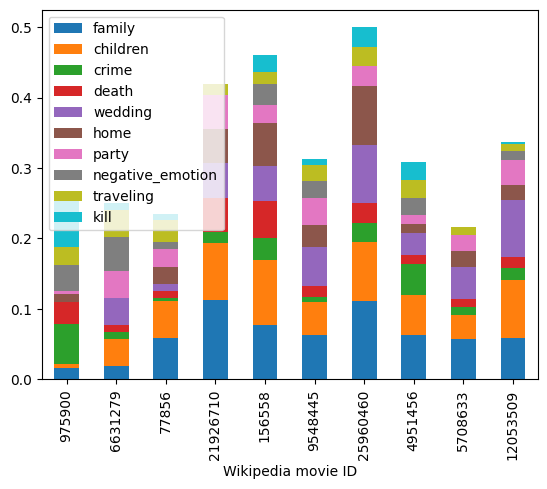

In [ ]:
# Ici on plot juste les 10 premiers films pour voir les top 10 catégories présentées (this is only a test)
empath_df[top_categories][:10].plot.bar(stacked=True)

In [126]:
# We look at who's more deadly 
top_deadly_movies = empath_df["death"].sort_values(ascending=False).index
top_deadly_movies

Index([27937333, 22348404, 14881706, 19155004,  2372198, 27904601, 10685113,
        6714641,  5747187, 31061078,
       ...
       19374957, 19398864, 17865807,   535453,   364541,  3602322,  6554925,
        3446942,  2239713, 35228177],
      dtype='int64', name='Wikipedia movie ID', length=17077)

<Axes: xlabel='Wikipedia movie ID'>

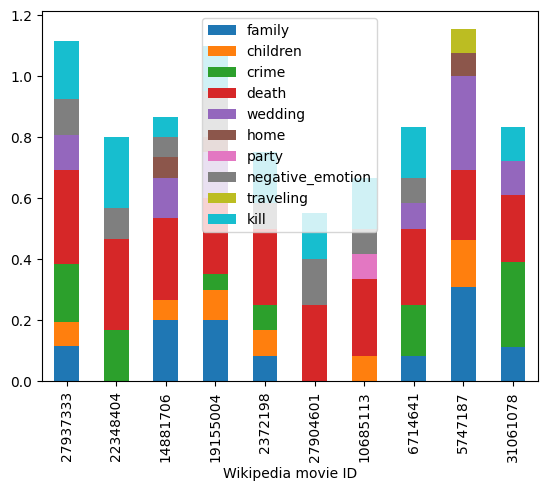

In [127]:
# We look the proportion of deadly in the movies that are classified as most deadly (above) -> still using the same 10 most categories
empath_df.sort_values(by="death", ascending=False)[top_categories][:10].plot.bar(stacked=True)

<Axes: xlabel='Wikipedia movie ID'>

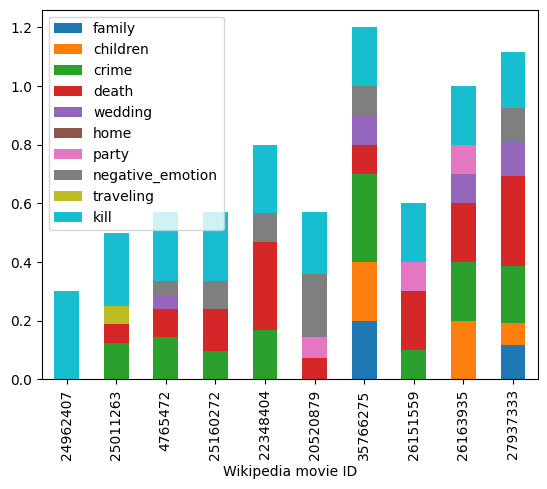

In [128]:
# We do the same but here we use "kill" as category to sort by
empath_df.sort_values(by="kill", ascending=False)[top_categories][:10].plot.bar(stacked=True)

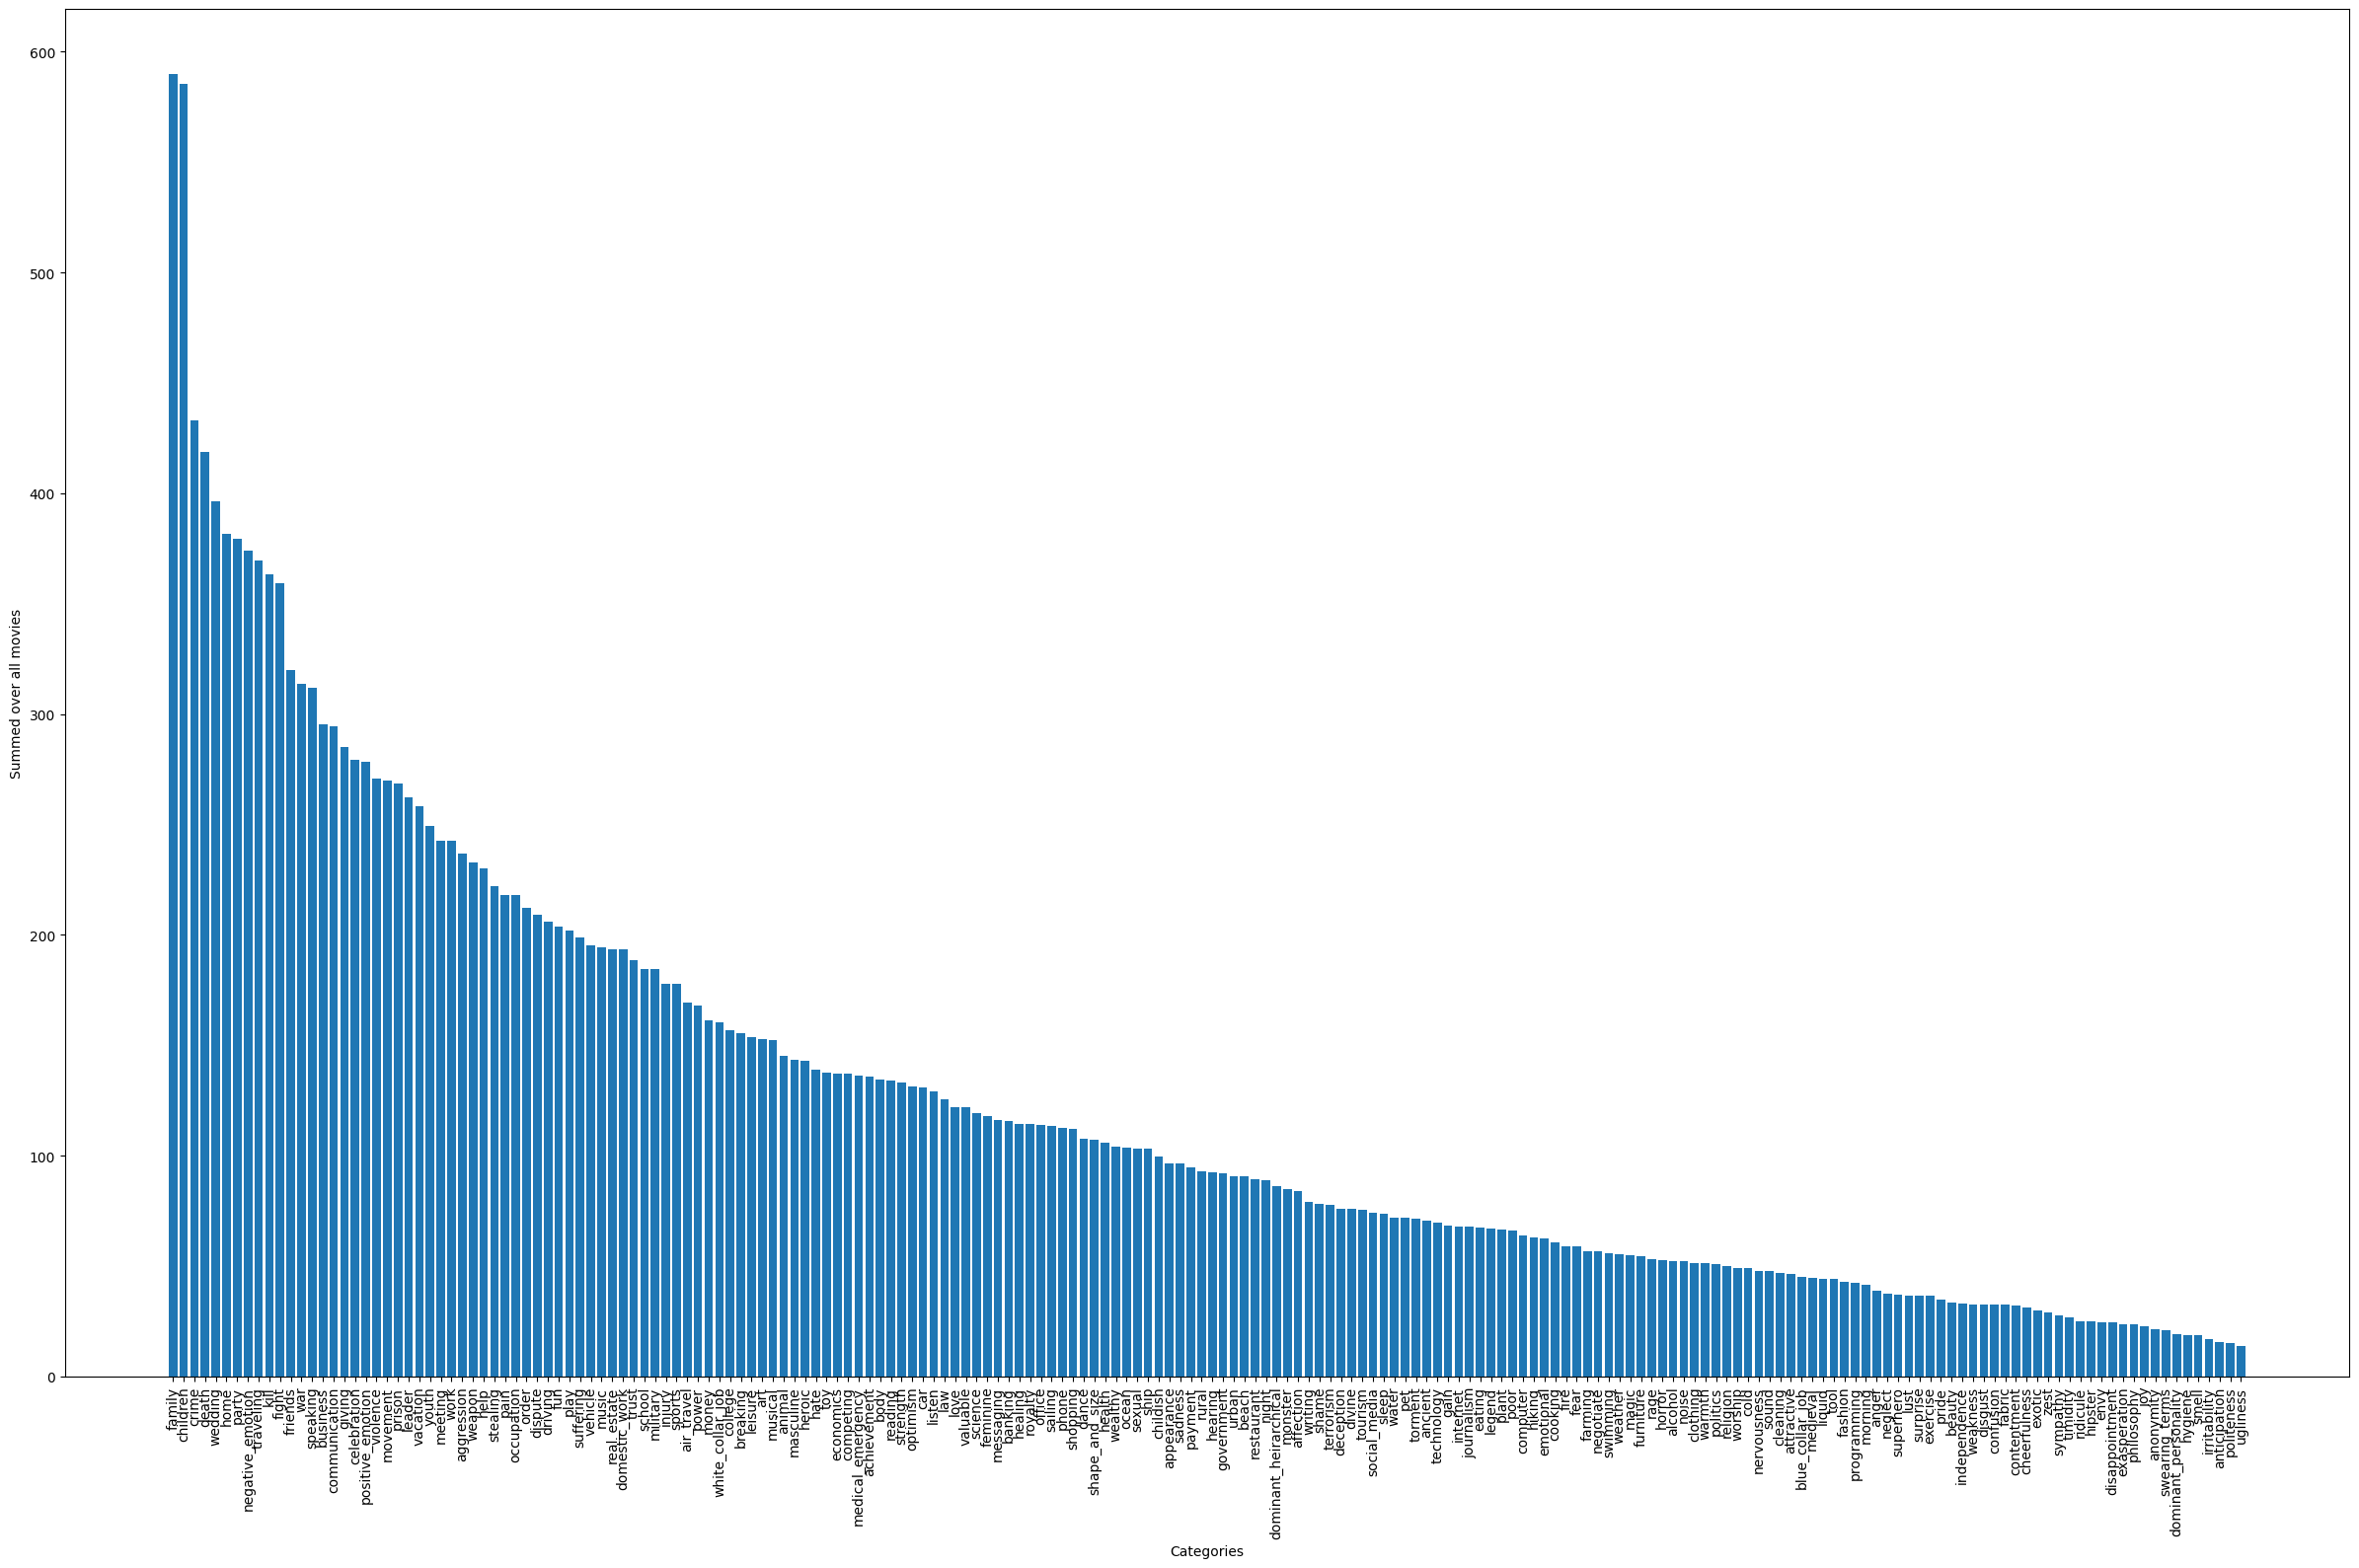

In [129]:
# Histogram for all categories

sorted_categories = empath_df.sum(axis=0).sort_values(ascending=False)

plt.figure(figsize=(24, 16))
plt.bar(sorted_categories.index, sorted_categories.values)
plt.xlabel("Categories")
plt.ylabel("Summed over all movies")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

In [37]:
# Quest-ce qui ferait du sens? Regarder les movies de Jade et voir si les categories qui ressortent le plus sont coherentes avec la calssification de Chat

<Axes: xlabel='Wikipedia movie ID'>

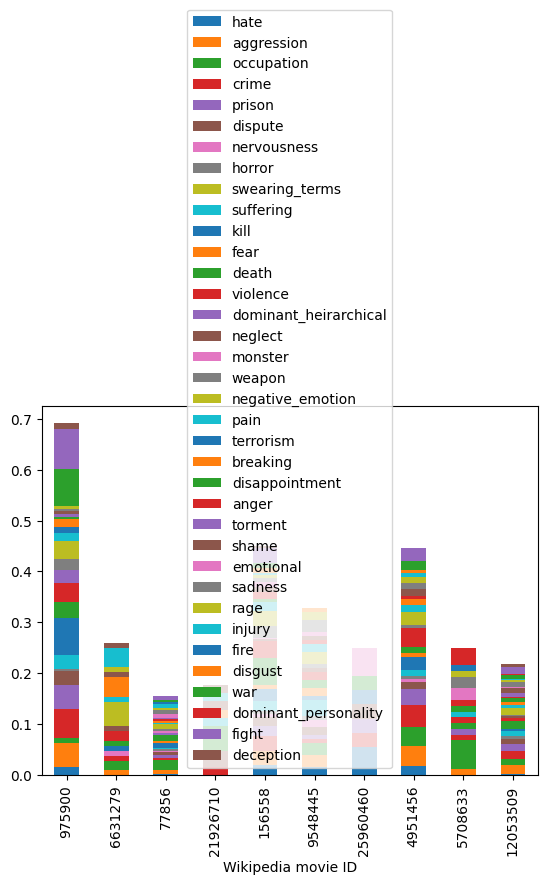

In [38]:
empath_df[violent_categories][:10].plot.bar(stacked=True)


<Axes: >

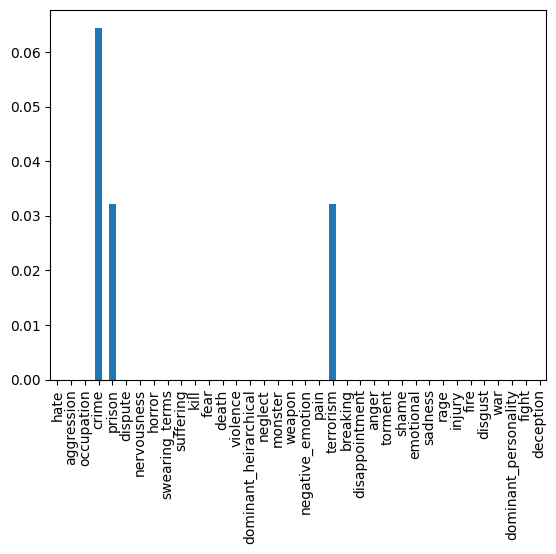

In [130]:
# Let's check for a movie that is known to be violent

empath_df[violent_categories].loc[28074095].plot.bar(stacked=True)

<Axes: >

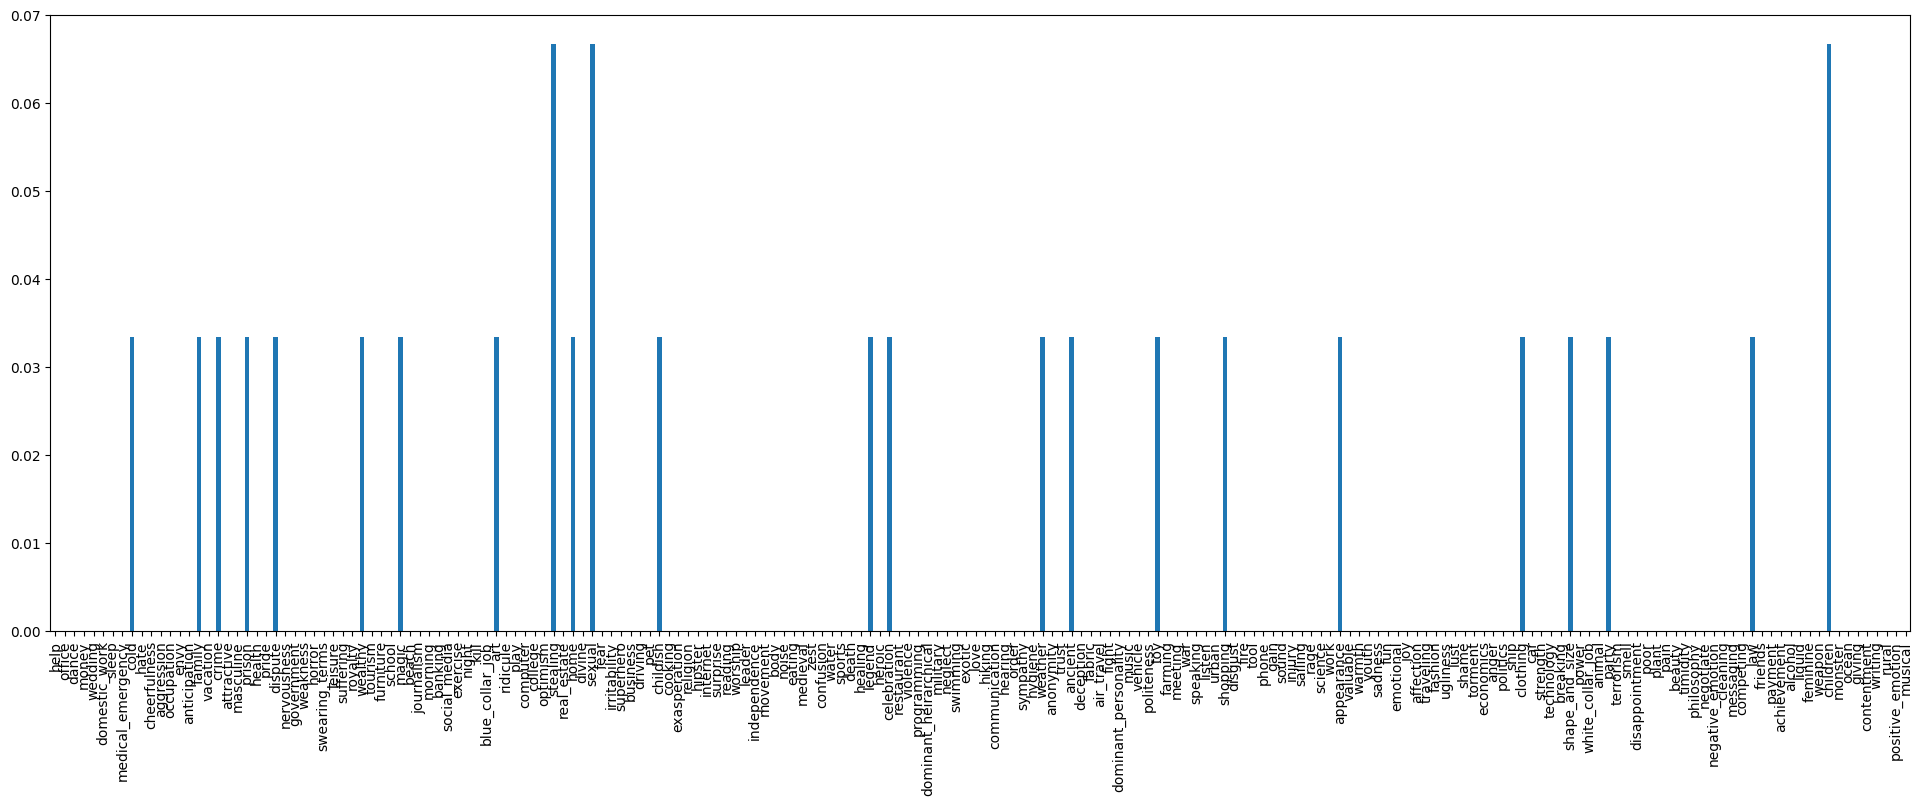

In [131]:
plt.figure(figsize=(24, 8))
empath_df.loc[3477618].plot.bar(stacked=True)

In [ ]:
# J'essaie sans normalizer a priori

In [ ]:
""" results_matrix = []

for idx, summary in enumerate(Movie_Data["Plot"]):
    #print("Movie {}: {}\n".format(idx, summary))
    
    # Preprocessing
    doc = nlp(summary)
    lemmatized_text = " ".join([token.lemma_ for token in doc if not token.is_stop and not token.is_punct])
    
    # Empath Analysis
    empath_features = lexicon.analyze(lemmatized_text)
    sorted_features = sorted(empath_features.items(), key=lambda x: x[1], reverse=True)
    
    # Append results to the matrix as a row
    results_matrix.append(empath_features)

# Create a DataFrame from the matrix
empath_df_non_normalized = pd.DataFrame(results_matrix, index=[f"Movie {i+1}" for i in range(len(Movie_Data["Plot"]))])

# Re-give the WIkipedia movie ID as index for each movie (bc they are treated as simple rows)
empath_df_non_normalized.index = Movie_Data["Wikipedia movie ID"]
display(empath_df_non_normalized)

# Save the DataFrame to a CSV file for further analysis
empath_df_non_normalized.to_csv('../data/CLEAN/empath_features_matrix_NON_NORMALIZED.tsv', sep="\t") """

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Movie 1,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,...,4.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0
Movie 2,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0
Movie 3,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,3.0,40.0,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0
Movie 4,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
Movie 5,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,6.0,...,7.0,28.0,1.0,0.0,2.0,1.0,0.0,5.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Movie 17073,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
Movie 17074,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,...,4.0,4.0,5.0,12.0,3.0,0.0,0.0,3.0,1.0,1.0
Movie 17075,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,...,1.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0
Movie 17076,3.0,7.0,0.0,1.0,6.0,0.0,1.0,2.0,0.0,4.0,...,3.0,2.0,0.0,0.0,3.0,0.0,1.0,0.0,2.0,0.0


In [148]:
empath_df_non_normalized = pd.read_csv('../data/CLEAN/empath_features_matrix_NON_NORMALIZED.tsv', sep="\t", index_col=0)
empath_df_non_normalized

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
975900,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,...,4.0,1.0,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0
6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0
77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,3.0,40.0,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0
21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
156558,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,6.0,...,7.0,28.0,1.0,0.0,2.0,1.0,0.0,5.0,5.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25011340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
7761830,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,...,4.0,4.0,5.0,12.0,3.0,0.0,0.0,3.0,1.0,1.0
1918494,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,...,1.0,2.0,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0


Explained Variance by Component: [0.34101327 0.10094863 0.04352481 0.03547734 0.03369198 0.02763137
 0.02149755 0.01948945 0.01754489 0.01726615]


<Axes: xlabel='PCA1', ylabel='PCA2'>

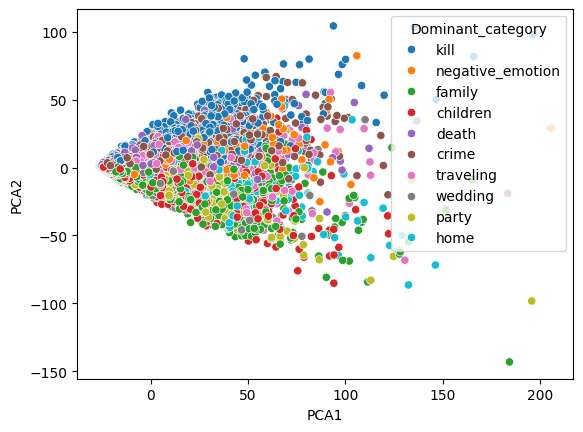

In [149]:
# on se lance dans la PCA parce que c'est cool (si on voit des clusters)

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import seaborn as sns

scaler = StandardScaler()
scaled_data = scaler.fit_transform(empath_df_non_normalized)

pca = PCA(n_components=10)
principal_components = pca.fit_transform(empath_df_non_normalized)

pca_df = pd.DataFrame(data=principal_components, columns=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8", "PCA9", "PCA10"])

pca_df.index = Movie_Data["Wikipedia movie ID"] # make sure they don't change the order
pca_df["Dominant_category"] = empath_df_non_normalized[top_categories].idxmax(axis=1)
#display(pca_df)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)

sns.scatterplot(pca_df, x="PCA1", y="PCA2", hue="Dominant_category")


<Axes: xlabel='PCA1', ylabel='PCA2'>

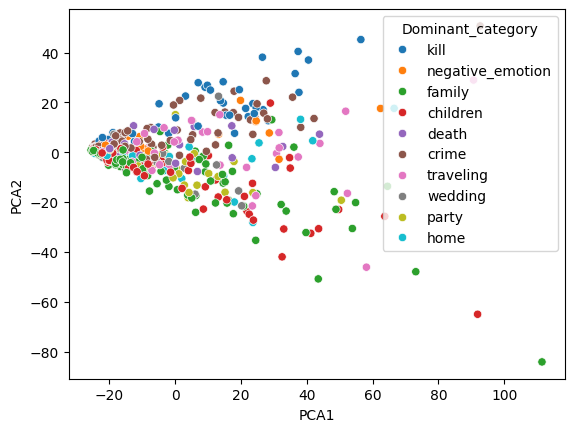

In [150]:
# on en fait seulement 500 pour être sûr qu'il n'y en ait pas de cachés en dessous
sns.scatterplot(pca_df[:500], x="PCA1", y="PCA2", hue="Dominant_category")

### 2. Let's now work on the LLM result

In [ ]:
# Let's look at the LLm result, first we twig a little the dataframe to set the index etc. 
LLM_results_df = pd.read_csv('../data/CLEAN/classification_result/model_1.csv')
LLM_results_df

,Wikipedia movie ID,Result,Prediction,Label
0,14168925,Violent,1.0,1
1,26057620,Violent,1.0,0
2,26015405,Violent,1.0,0
3,34954266,Peaceful,-1.0,-1
4,15217227,Peaceful,-1.0,-1
...,...,...,...,...
111,29499560,Violent,1.0,1
112,27606335,Mild,0.0,-1
113,14613957,Violent,1.0,1
114,1472852,Peaceful,-1.0,-1


In [152]:
LLM_results_df_violent = LLM_results_df[LLM_results_df["Prediction"] == 1.0]
LLM_results_df_violent

,Wikipedia movie ID,Result,Prediction,Label
0,14168925,Violent,1.0,1
1,26057620,Violent,1.0,0
2,26015405,Violent,1.0,0
14,12048544,Violent,1.0,1
17,3477618,Violent,1.0,0
19,14881706,Violent,1.0,1
22,29584842,Violent,1.0,1
25,4481850,Violent,1.0,0
32,24665535,Violent,1.0,1
35,6714641,Violent,1.0,1


In [153]:
violent_merged = empath_df_non_normalized.merge(LLM_results_df_violent, how='left', on='Wikipedia movie ID')
violent_merged

,Wikipedia movie ID,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,...,ocean,giving,contentment,writing,rural,positive_emotion,musical,Result,Prediction,Label
0,975900,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN
1,6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,...,0.0,2.0,1.0,0.0,0.0,2.0,1.0,NaN,NaN,NaN
2,77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,...,1.0,19.0,0.0,6.0,3.0,13.0,8.0,NaN,NaN,NaN
3,21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4.0,0.0,NaN,NaN,NaN
4,156558,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,...,0.0,2.0,1.0,0.0,5.0,5.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17072,25011340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
17073,7761830,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,12.0,3.0,0.0,0.0,3.0,1.0,1.0,NaN,NaN,NaN
17074,1918494,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,...,0.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN
17075,664006,3.0,7.0,0.0,1.0,6.0,0.0,1.0,2.0,0.0,...,0.0,3.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN


In [158]:
violent_merged_copy = violent_merged.copy()
""" violent_merged_copy.dropna(inplace=True)
violent_merged_copy.drop(columns=["Result", "Prediction", "Label"], inplace=True)
"""
violent_merged_copy

,Wikipedia movie ID,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,...,ocean,giving,contentment,writing,rural,positive_emotion,musical,Result,Prediction,Label
0,975900,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN,NaN
1,6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,...,0.0,2.0,1.0,0.0,0.0,2.0,1.0,NaN,NaN,NaN
2,77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,...,1.0,19.0,0.0,6.0,3.0,13.0,8.0,NaN,NaN,NaN
3,21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,4.0,0.0,NaN,NaN,NaN
4,156558,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,...,0.0,2.0,1.0,0.0,5.0,5.0,1.0,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17072,25011340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN
17073,7761830,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,...,12.0,3.0,0.0,0.0,3.0,1.0,1.0,NaN,NaN,NaN
17074,1918494,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,...,0.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN,NaN
17075,664006,3.0,7.0,0.0,1.0,6.0,0.0,1.0,2.0,0.0,...,0.0,3.0,0.0,1.0,0.0,2.0,0.0,NaN,NaN,NaN


<Axes: >

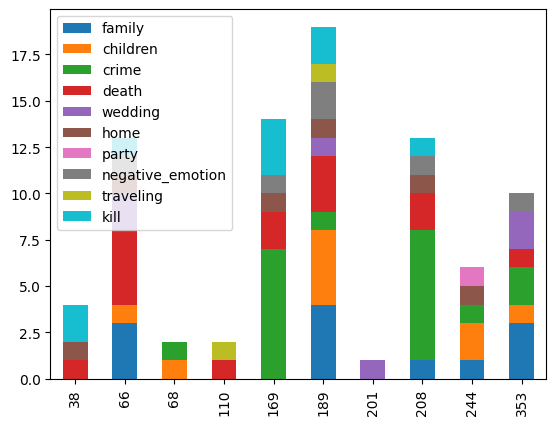

In [156]:
violent_merged_copy[top_categories][:10].plot.bar(stacked=True)

<Axes: xlabel='Wikipedia movie ID'>

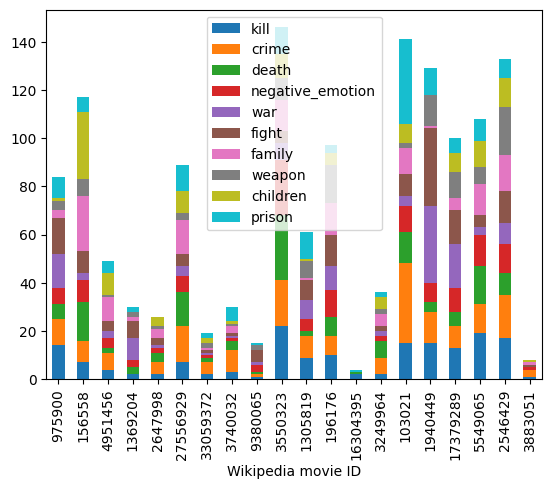

In [ ]:
top_categories_violent = violent_merged_copy.sum(axis=0).sort_values(ascending=False).head(10).index
violent_merged_copy[top_categories_violent][:20].plot.bar(stacked=True)

### Movie dataframe 

In [ ]:
LLM_results_df_nonviolent = LLM_results_df[LLM_results_df["Prediction"] == -1.0]
LLM_results_df_nonviolent

,Result,Prediction
Wikipedia movie ID,,
6631279,Peaceful,-1.0
77856,Peaceful,-1.0
21926710,Peaceful,-1.0
9548445,Peaceful,-1.0
25960460,Peaceful,-1.0
...,...,...
12696181,Peaceful,-1.0
4492078,Peaceful,-1.0
30553937,Peaceful,-1.0


In [ ]:
nonviolent_merged = empath_df_non_normalized.merge(LLM_results_df_nonviolent, how='left', on='Wikipedia movie ID')
nonviolent_merged

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,Result,Prediction
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
975900,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,Peaceful,-1.0
77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0,Peaceful,-1.0
21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,Peaceful,-1.0
156558,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,6.0,...,1.0,0.0,2.0,1.0,0.0,5.0,5.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25011340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
7761830,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,...,5.0,12.0,3.0,0.0,0.0,3.0,1.0,1.0,NaN,NaN
1918494,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,NaN,NaN


In [ ]:
nonviolent_merged_copy = nonviolent_merged.copy()
nonviolent_merged_copy.dropna(inplace=True)
nonviolent_merged_copy.drop(columns=["Result", "Prediction"], inplace=True)
nonviolent_merged_copy

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0
77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,3.0,40.0,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0
21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
9548445,3.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,2.0,...,1.0,6.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0
25960460,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
12696181,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
4492078,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,0.0
30553937,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


<Axes: xlabel='Wikipedia movie ID'>

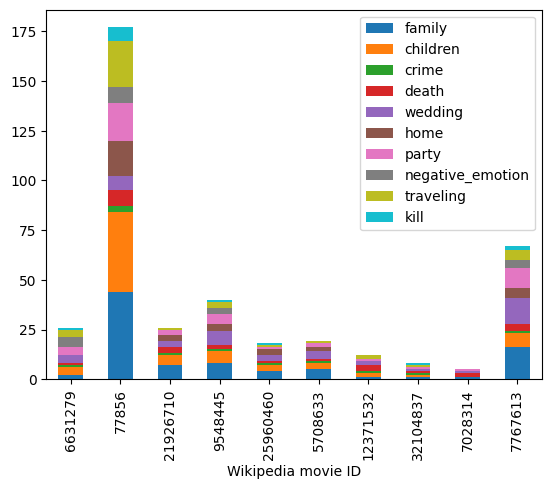

In [ ]:
nonviolent_merged_copy[top_categories][:10].plot.bar(stacked=True)

<Axes: xlabel='Wikipedia movie ID'>

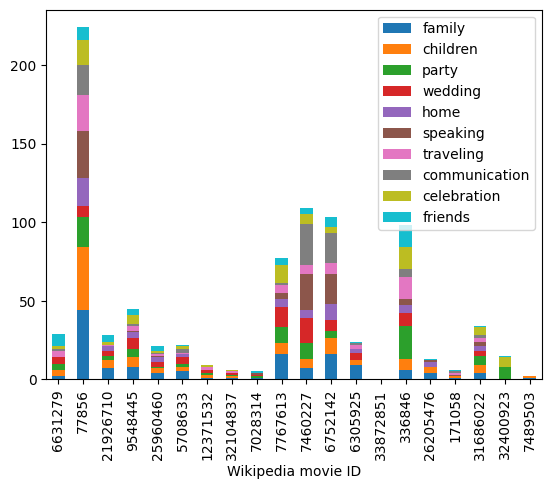

In [ ]:
top_categories_nonviolent = nonviolent_merged_copy.sum(axis=0).sort_values(ascending=False).head(10).index
nonviolent_merged_copy[top_categories_nonviolent][:20].plot.bar(stacked=True)

In [ ]:
LLM_results_df_mild = LLM_results_df[LLM_results_df["Prediction"] == 0.0]
LLM_results_df_mild

,Result,Prediction
Wikipedia movie ID,,
12053509,Mild,0.0
5664529,Mild,0.0
5894429,Mild,0.0
12788657,Mild,0.0
2154704,Mild,0.0
...,...,...
11350779,Mild,0.0
1673588,Mild,0.0
22330502,Mild,0.0


In [ ]:
mild_merged = empath_df_non_normalized.merge(LLM_results_df_mild, how='left', on='Wikipedia movie ID')
mild_merged

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,Result,Prediction
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
975900,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,NaN,NaN
77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0,NaN,NaN
21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,NaN,NaN
156558,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,6.0,...,1.0,0.0,2.0,1.0,0.0,5.0,5.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25011340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
7761830,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,...,5.0,12.0,3.0,0.0,0.0,3.0,1.0,1.0,Mild,0.0
1918494,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,Mild,0.0


In [ ]:
mild_merged_copy = mild_merged.copy()
mild_merged_copy.dropna(inplace=True)
mild_merged_copy.drop(columns=["Result", "Prediction"], inplace=True)
mild_merged_copy

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
12053509,4.0,1.0,1.0,8.0,25.0,3.0,2.0,2.0,0.0,1.0,...,1.0,26.0,0.0,0.0,20.0,1.0,1.0,1.0,2.0,0.0
5664529,1.0,1.0,0.0,0.0,4.0,2.0,0.0,0.0,0.0,1.0,...,0.0,4.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0
5894429,3.0,0.0,0.0,0.0,5.0,0.0,0.0,3.0,0.0,0.0,...,3.0,10.0,0.0,0.0,1.0,0.0,2.0,1.0,9.0,0.0
12788657,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2154704,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11350779,6.0,3.0,3.0,1.0,5.0,2.0,1.0,3.0,2.0,3.0,...,8.0,3.0,0.0,2.0,2.0,0.0,2.0,2.0,1.0,3.0
1673588,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,4.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0
22330502,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0


<Axes: xlabel='Wikipedia movie ID'>

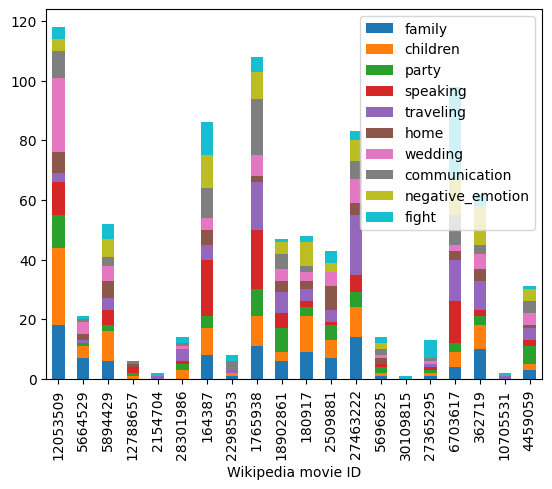

In [ ]:
top_categories_mild = mild_merged_copy.sum(axis=0).sort_values(ascending=False).head(10).index
mild_merged_copy[top_categories_mild][:20].plot.bar(stacked=True)

In [ ]:
LLM_results_df_nonviolent = LLM_results_df[LLM_results_df["Prediction"] == -1.0]
LLM_results_df_nonviolent

Explained Variance by Component: [0.36732509 0.06427851 0.04783398 0.03899608 0.03365892 0.02506007
 0.02223626 0.02163384 0.0195152  0.01791274]


<Axes: xlabel='PCA1', ylabel='PCA2'>

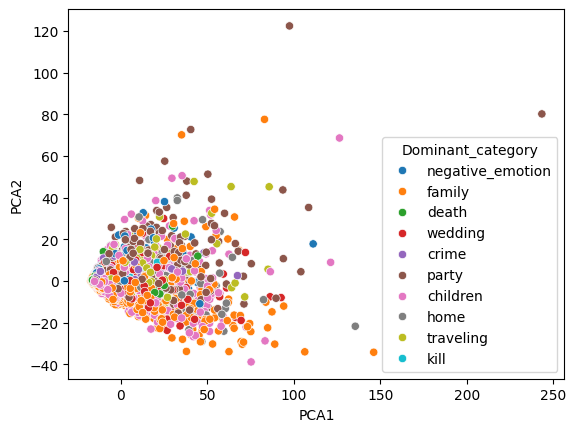

In [ ]:
scaler = StandardScaler()
scaled_data = scaler.fit_transform(nonviolent_merged_copy)

pca = PCA(n_components=10)
principal_components = pca.fit_transform(nonviolent_merged_copy)

pca_df = pd.DataFrame(data=principal_components, columns=["PCA1", "PCA2", "PCA3", "PCA4", "PCA5", "PCA6", "PCA7", "PCA8", "PCA9", "PCA10"])

pca_df.index = nonviolent_merged_copy.index # make sure they don't change the order
pca_df["Dominant_category"] = nonviolent_merged_copy[top_categories].idxmax(axis=1)
#display(pca_df)

explained_variance = pca.explained_variance_ratio_
print("Explained Variance by Component:", explained_variance)

sns.scatterplot(pca_df, x="PCA1", y="PCA2", hue="Dominant_category")

### Let's now do the same but with the binary

In [44]:
LLM_binary_df = pd.read_csv('../data/CLEAN/classification_result/LLM_result_binary.csv')
LLM_binary_df.index = LLM_binary_df["Wikipedia movie ID"]
LLM_binary_df.drop(columns=["Wikipedia movie ID"], inplace=True)
LLM_binary_df

,Result,Prediction
Wikipedia movie ID,,
975900,Violent,1.0
6631279,Non-violent,-1.0
77856,Non-violent,-1.0
21926710,Non-violent,-1.0
156558,Violent,1.0
...,...,...
25011340,Violent,1.0
7761830,Violent,1.0
1918494,Non-violent,-1.0


In [45]:
LLM_binary_df_violent = LLM_binary_df[LLM_binary_df["Prediction"] == 1.0]
LLM_binary_df_violent

,Result,Prediction
Wikipedia movie ID,,
975900,Violent,1.0
156558,Violent,1.0
4951456,Violent,1.0
1369204,Violent,1.0
2647998,Violent,1.0
...,...,...
25920477,Violent,1.0
11350779,Violent,1.0
25011340,Violent,1.0


In [ ]:
violent_binary_merged = empath_df_non_normalized.merge(LLM_binary_df_violent, how='left', on='Wikipedia movie ID')
violent_binary_merged

NameError: name 'empath_df_non_normalized' is not defined

In [ ]:
violent_binary_merged_copy = violent_binary_merged.copy()
violent_binary_merged_copy.dropna(inplace=True)
violent_binary_merged_copy.drop(columns=["Result", "Prediction"], inplace=True)
violent_binary_merged_copy

NameError: name 'violent_binary_merged' is not defined

<Axes: xlabel='Wikipedia movie ID'>

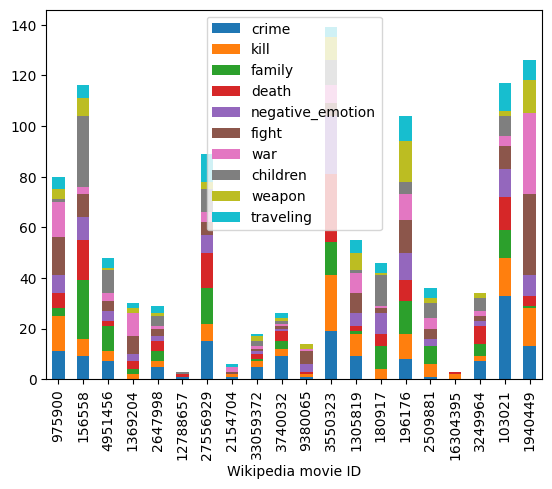

In [ ]:
top_categories_binary_violent = violent_binary_merged_copy.sum(axis=0).sort_values(ascending=False).head(10).index
violent_binary_merged_copy[top_categories_binary_violent][:20].plot.bar(stacked=True)

In [ ]:
LLM_binary_df_nonviolent = LLM_binary_df[LLM_binary_df["Prediction"] == -1.0]
LLM_binary_df_nonviolent

,Result,Prediction
Wikipedia movie ID,,
6631279,Non-violent,-1.0
77856,Non-violent,-1.0
21926710,Non-violent,-1.0
9548445,Non-violent,-1.0
25960460,Non-violent,-1.0
...,...,...
54540,Non-violent,-1.0
1673588,Non-violent,-1.0
22330502,Non-violent,-1.0


In [ ]:
nonviolent_binary_merged = empath_df_non_normalized.merge(LLM_binary_df_nonviolent, how='left', on='Wikipedia movie ID')
nonviolent_binary_merged

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical,Result,Prediction
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
975900,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,3.0,...,0.0,0.0,4.0,0.0,0.0,0.0,1.0,0.0,NaN,NaN
6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0,Non-violent,-1.0
77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0,Non-violent,-1.0
21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0,Non-violent,-1.0
156558,5.0,3.0,0.0,3.0,15.0,6.0,0.0,1.0,2.0,6.0,...,1.0,0.0,2.0,1.0,0.0,5.0,5.0,1.0,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25011340,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,NaN,NaN
7761830,6.0,2.0,1.0,0.0,1.0,1.0,1.0,1.0,1.0,4.0,...,5.0,12.0,3.0,0.0,0.0,3.0,1.0,1.0,NaN,NaN
1918494,1.0,1.0,0.0,4.0,0.0,0.0,0.0,2.0,0.0,1.0,...,0.0,0.0,2.0,1.0,1.0,1.0,2.0,2.0,Non-violent,-1.0


In [ ]:
nonviolent_binary_merged_copy = nonviolent_binary_merged.copy()
nonviolent_binary_merged_copy.dropna(inplace=True)
nonviolent_binary_merged_copy.drop(columns=["Result", "Prediction"], inplace=True)
nonviolent_binary_merged_copy

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
6631279,1.0,0.0,0.0,0.0,4.0,1.0,1.0,1.0,1.0,0.0,...,0.0,4.0,0.0,0.0,2.0,1.0,0.0,0.0,2.0,1.0
77856,4.0,2.0,6.0,36.0,7.0,19.0,4.0,3.0,6.0,2.0,...,3.0,40.0,2.0,1.0,19.0,0.0,6.0,3.0,13.0,8.0
21926710,1.0,0.0,0.0,0.0,3.0,1.0,1.0,0.0,0.0,0.0,...,0.0,5.0,0.0,0.0,0.0,0.0,0.0,1.0,4.0,0.0
9548445,3.0,0.0,0.0,1.0,7.0,1.0,0.0,0.0,0.0,2.0,...,1.0,6.0,0.0,0.0,2.0,1.0,0.0,1.0,1.0,1.0
25960460,1.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,2.0,...,0.0,3.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
54540,6.0,0.0,1.0,5.0,22.0,2.0,2.0,0.0,0.0,1.0,...,0.0,6.0,0.0,1.0,6.0,0.0,0.0,1.0,5.0,0.0
1673588,0.0,0.0,0.0,1.0,0.0,2.0,0.0,0.0,0.0,0.0,...,0.0,4.0,3.0,1.0,2.0,0.0,0.0,0.0,1.0,1.0
22330502,0.0,0.0,0.0,1.0,2.0,0.0,1.0,0.0,0.0,1.0,...,0.0,2.0,0.0,0.0,2.0,0.0,2.0,2.0,2.0,2.0


<Axes: xlabel='Wikipedia movie ID'>

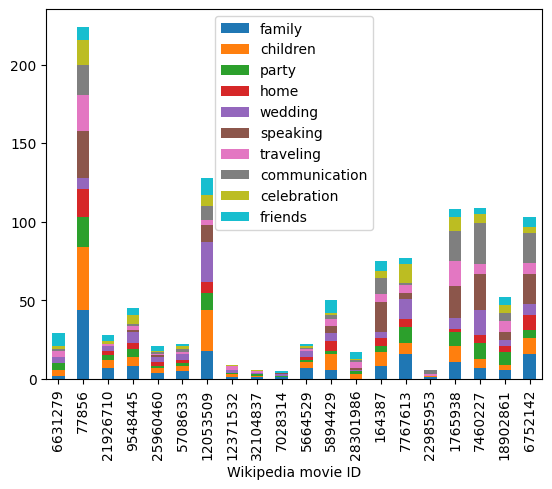

In [ ]:
top_categories_binary_nonviolent = nonviolent_binary_merged_copy.sum(axis=0).sort_values(ascending=False).head(10).index
nonviolent_binary_merged_copy[top_categories_binary_nonviolent][:20].plot.bar(stacked=True)

## DATAFRAME FOR RAPHAEL

In [46]:
Movie_Data

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Languages,Countries,Genres,Plot
0,975900,Ghosts of Mars,2001-08-24,14010832.0,English Language,United States of America,"Thriller, Science Fiction, Horror, Adventure, ...","set in the second half of the 22nd century, th..."
1,6631279,Little city,1997-04-04,NaN,English Language,United States of America,"Romantic comedy, Ensemble Film, Comedy-drama, ...","adam, a san francisco-based artist who works a..."
2,77856,Mary Poppins,1964-08-27,102272727.0,English Language,United States of America,"Children's/Family, Musical, Fantasy, Comedy, D...",the film opens with mary poppins perched in a...
3,21926710,White on Rice,2009-05-31,NaN,NaN,United States of America,"Romantic comedy, Romance Film, Comedy, Indie",jimmy ([[hiroshi watanabe loves dinosaurs and...
4,156558,Baby Boy,2001-06-27,29381649.0,English Language,United States of America,"Crime Fiction, Drama, Coming of age",a young 20-year-old named jody lives with his...
...,...,...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,NaN,United States of America,"Thriller, Crime Thriller, Action, Psychologica...","charlie daines , is a morphine-addicted detect..."
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,English Language,United States of America,"Alien Film, Science Fiction, Family Film, Come...","the space armada from mars, known as the imper..."
17074,1918494,State and Main,2000-08-26,6944471.0,"Italian Language, English Language","France, United States of America","Parody, Americana, Comedy",havoc is wrought on the inhabitants of a small...
17075,664006,Guilty as Sin,1993-06-04,22886222.0,NaN,United States of America,"Thriller, Erotic thriller, Psychological thril...",jennifer haines is an up-and-coming chicago a...


In [47]:
# test 
import datetime

dates = pd.to_datetime(Movie_Data["Release date"])
dates

0       2001-08-24
1       1997-04-04
2       1964-08-27
3       2009-05-31
4       2001-06-27
           ...    
17072   2005-03-08
17073   1990-04-27
17074   2000-08-26
17075   1993-06-04
17076   2011-03-19
Name: Release date, Length: 17077, dtype: datetime64[ns]

In [48]:
# test
dates.dt.year

0        2001
1        1997
2        1964
3        2009
4        2001
         ... 
17072    2005
17073    1990
17074    2000
17075    1993
17076    2011
Name: Release date, Length: 17077, dtype: int32

In [49]:
# test
dates.dt.isocalendar().week

0        34
1        14
2        35
3        22
4        26
         ..
17072    10
17073    17
17074    34
17075    22
17076    11
Name: week, Length: 17077, dtype: UInt32

In [50]:
Movie_Data_autoregressive = Movie_Data.copy()
Movie_Data_autoregressive.drop(columns=["Languages", "Countries", "Genres", "Plot"], inplace=True)
Movie_Data_autoregressive

,Wikipedia movie ID,Movie name,Release date,Box office revenue
0,975900,Ghosts of Mars,2001-08-24,14010832.0
1,6631279,Little city,1997-04-04,NaN
2,77856,Mary Poppins,1964-08-27,102272727.0
3,21926710,White on Rice,2009-05-31,NaN
4,156558,Baby Boy,2001-06-27,29381649.0
...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN
17073,7761830,Spaced Invaders,1990-04-27,15369573.0
17074,1918494,State and Main,2000-08-26,6944471.0
17075,664006,Guilty as Sin,1993-06-04,22886222.0


In [51]:
# Let's take care of the dates to have the (Week - Year) format

Movie_Data_autoregressive["Year"] = pd.to_datetime(Movie_Data["Release date"]).dt.year
Movie_Data_autoregressive["Week"] = pd.to_datetime(Movie_Data["Release date"]).dt.isocalendar().week
Movie_Data_autoregressive

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week
0,975900,Ghosts of Mars,2001-08-24,14010832.0,2001,34
1,6631279,Little city,1997-04-04,NaN,1997,14
2,77856,Mary Poppins,1964-08-27,102272727.0,1964,35
3,21926710,White on Rice,2009-05-31,NaN,2009,22
4,156558,Baby Boy,2001-06-27,29381649.0,2001,26
...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,2005,10
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,1990,17
17074,1918494,State and Main,2000-08-26,6944471.0,2000,34
17075,664006,Guilty as Sin,1993-06-04,22886222.0,1993,22


In [52]:
LLM_binary_df = pd.read_csv('../data/CLEAN/classification_result/LLM_result_binary.csv')
LLM_binary_df

,Wikipedia movie ID,Result,Prediction
0,975900,Violent,1.0
1,6631279,Non-violent,-1.0
2,77856,Non-violent,-1.0
3,21926710,Non-violent,-1.0
4,156558,Violent,1.0
...,...,...,...
17059,25011340,Violent,1.0
17060,7761830,Violent,1.0
17061,1918494,Non-violent,-1.0
17062,664006,Violent,1.0


In [53]:
LLM_binary_df_violent = LLM_binary_df[LLM_binary_df["Prediction"] == 1.0]
LLM_binary_df_violent

,Wikipedia movie ID,Result,Prediction
0,975900,Violent,1.0
4,156558,Violent,1.0
7,4951456,Violent,1.0
10,1369204,Violent,1.0
13,2647998,Violent,1.0
...,...,...,...
17051,25920477,Violent,1.0
17055,11350779,Violent,1.0
17059,25011340,Violent,1.0
17060,7761830,Violent,1.0


In [54]:
Violent_Movies_autoregressive = Movie_Data_autoregressive.merge(LLM_binary_df_violent, how='left', on='Wikipedia movie ID')
Violent_Movies_autoregressive

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week,Result,Prediction
0,975900,Ghosts of Mars,2001-08-24,14010832.0,2001,34,Violent,1.0
1,6631279,Little city,1997-04-04,NaN,1997,14,NaN,NaN
2,77856,Mary Poppins,1964-08-27,102272727.0,1964,35,NaN,NaN
3,21926710,White on Rice,2009-05-31,NaN,2009,22,NaN,NaN
4,156558,Baby Boy,2001-06-27,29381649.0,2001,26,Violent,1.0
...,...,...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,2005,10,Violent,1.0
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,1990,17,Violent,1.0
17074,1918494,State and Main,2000-08-26,6944471.0,2000,34,NaN,NaN
17075,664006,Guilty as Sin,1993-06-04,22886222.0,1993,22,Violent,1.0


In [55]:
Violent_Movies_autoregressive.dropna(subset=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive.drop(columns=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive.index = Violent_Movies_autoregressive["Wikipedia movie ID"]
Violent_Movies_autoregressive.drop(columns=["Wikipedia movie ID"], inplace=True)

In [56]:
Violent_Movies_autoregressive

,Movie name,Release date,Box office revenue,Year,Week
Wikipedia movie ID,,,,,
975900,Ghosts of Mars,2001-08-24,14010832.0,2001,34
156558,Baby Boy,2001-06-27,29381649.0,2001,26
4951456,Kinjite: Forbidden Subjects,1989-02-03,3416846.0,1989,5
1369204,Juarez,1939-06-10,NaN,1939,23
2647998,The Human Tornado,1976-10-02,NaN,1976,40
...,...,...,...,...,...
25920477,Source Code,2011-03-11,147332697.0,2011,10
11350779,Sherlock Holmes and the Voice of Terror,1942-09-18,NaN,1942,38
25011340,Dot.Kill,2005-03-08,NaN,2005,10


In [57]:
# Save the DataFrame to a CSV file for the autoregressive model
Violent_Movies_autoregressive.to_csv('../data/CLEAN/Violent_Movies_final.tsv', sep="\t")

In [58]:
# Let's just check that the nonviolent are the other half of the movies
LLM_binary_df_nonviolent = LLM_binary_df[LLM_binary_df["Prediction"] == -1.0]
LLM_binary_df_nonviolent

Violent_Movies_autoregressive_discarded = Movie_Data_autoregressive.merge(LLM_binary_df_nonviolent, how='left', on='Wikipedia movie ID')
Violent_Movies_autoregressive_discarded

Violent_Movies_autoregressive_discarded.dropna(subset=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive_discarded.drop(columns=["Result", "Prediction"], inplace=True)
Violent_Movies_autoregressive_discarded

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week
1,6631279,Little city,1997-04-04,NaN,1997,14
2,77856,Mary Poppins,1964-08-27,102272727.0,1964,35
3,21926710,White on Rice,2009-05-31,NaN,2009,22
5,9548445,Archie: To Riverdale and Back Again,1990-05-06,NaN,1990,18
6,25960460,Daddy and Them,2001-10-26,NaN,2001,43
...,...,...,...,...,...,...
17069,54540,Coming to America,1988-06-29,288752301.0,1988,26
17070,1673588,The Brother from Another Planet,1984-09-07,NaN,1984,36
17071,22330502,Inspiration,1931-01-31,NaN,1931,5
17074,1918494,State and Main,2000-08-26,6944471.0,2000,34


### Okay but I want to see if I can plot this by year now

In [59]:
violent_movies_final = pd.read_csv('../data/CLEAN/Violent_Movies_final.tsv', sep="\t")
violent_movies_final

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week
0,975900,Ghosts of Mars,2001-08-24,14010832.0,2001,34
1,156558,Baby Boy,2001-06-27,29381649.0,2001,26
2,4951456,Kinjite: Forbidden Subjects,1989-02-03,3416846.0,1989,5
3,1369204,Juarez,1939-06-10,NaN,1939,23
4,2647998,The Human Tornado,1976-10-02,NaN,1976,40
...,...,...,...,...,...,...
8256,25920477,Source Code,2011-03-11,147332697.0,2011,10
8257,11350779,Sherlock Holmes and the Voice of Terror,1942-09-18,NaN,1942,38
8258,25011340,Dot.Kill,2005-03-08,NaN,2005,10
8259,7761830,Spaced Invaders,1990-04-27,15369573.0,1990,17


In [60]:
violent_movies_by_year = violent_movies_final.groupby(['Year', 'Week']).size().reset_index(name='Count')
violent_movies_by_year.sort_values(by=['Year', 'Week'])
violent_movies_by_year

,Year,Week,Count
0,1901,8,1
1,1903,49,1
2,1908,10,1
3,1908,29,1
4,1908,30,1
...,...,...,...
3496,2016,26,1
3497,2016,33,1
3498,2016,36,1
3499,2017,8,1


In [61]:
violent_movies_by_year['Year-Week'] = violent_movies_by_year['Year'].astype(str) +"-W"+ violent_movies_by_year['Week'].astype(str)
violent_movies_by_year

,Year,Week,Count,Year-Week
0,1901,8,1,1901-W8
1,1903,49,1,1903-W49
2,1908,10,1,1908-W10
3,1908,29,1,1908-W29
4,1908,30,1,1908-W30
...,...,...,...,...
3496,2016,26,1,2016-W26
3497,2016,33,1,2016-W33
3498,2016,36,1,2016-W36
3499,2017,8,1,2017-W8


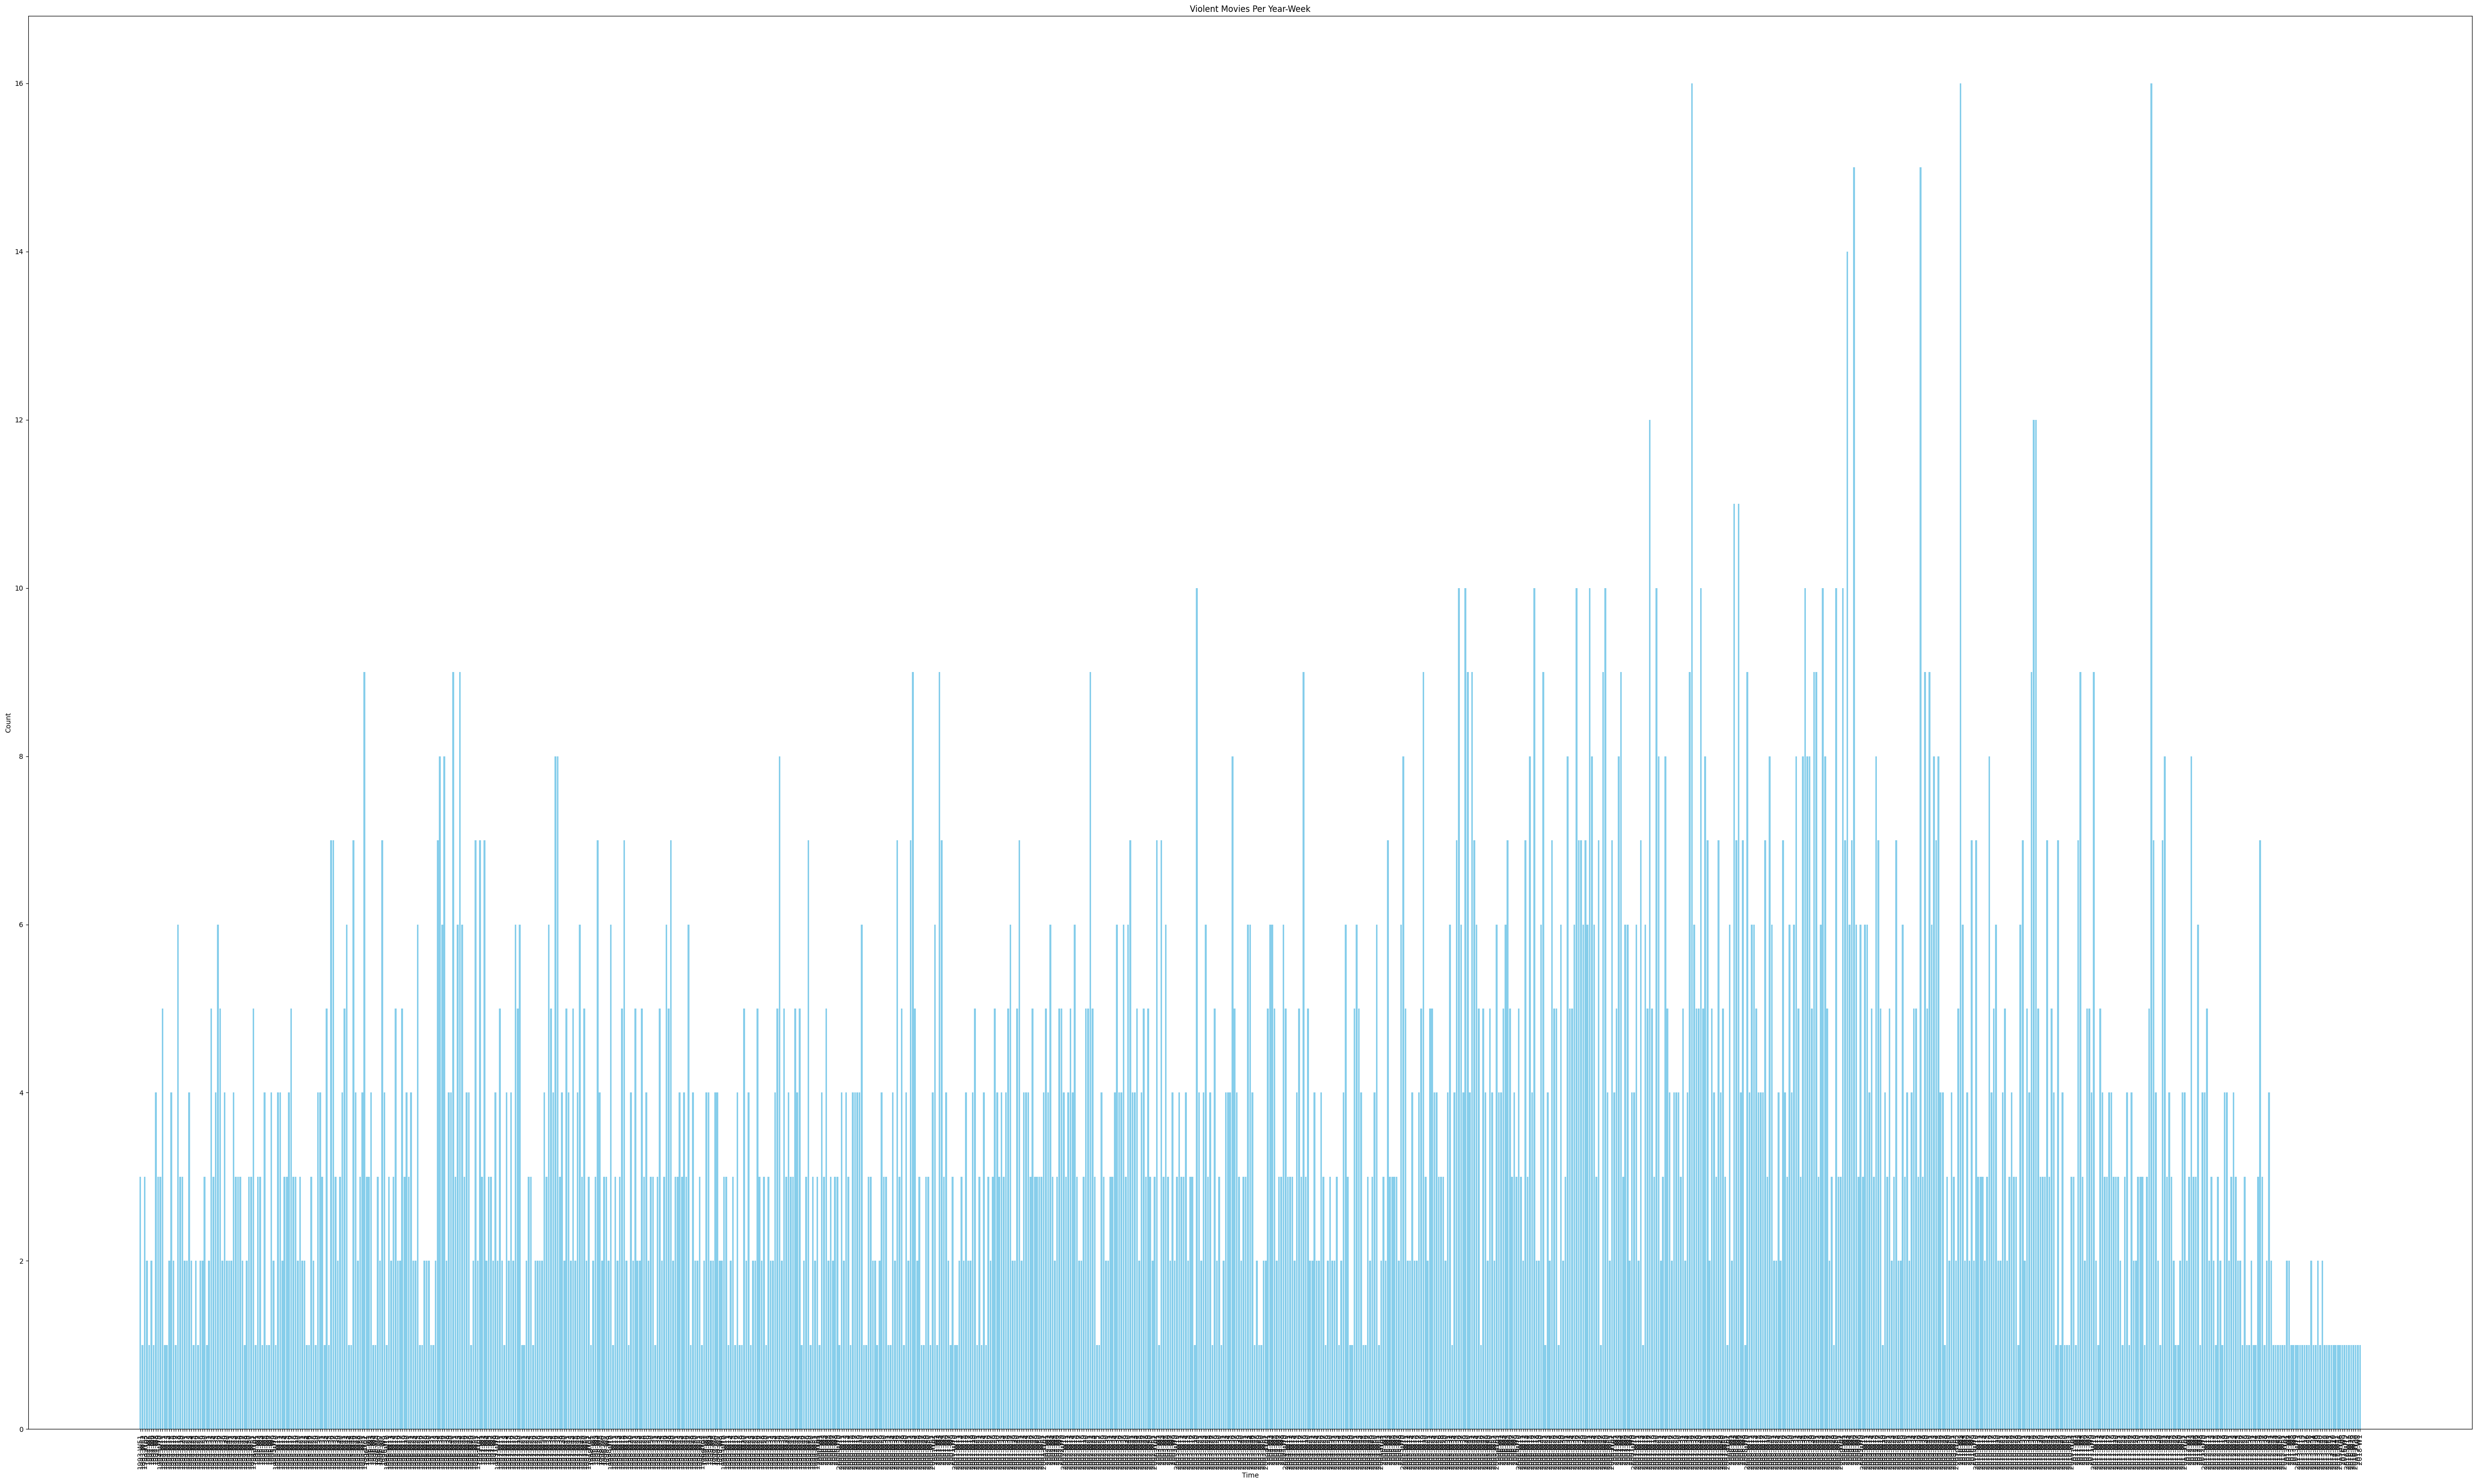

In [64]:
import matplotlib.pyplot as plt

plt.figure(figsize=(50, 30))
plt.bar(
    violent_movies_by_year['Year-Week'][2500:],  # X-axis: Date labels (Year-Week)
    violent_movies_by_year['Count'][2500:],     # Y-axis: Count of events
    color='skyblue'
)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Violent Movies Per Year-Week')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
#let's try by year only just bc otherwise I cry
violent_movies_by_YEAR = violent_movies_final.groupby(['Year']).size().reset_index(name='Count')
violent_movies_by_YEAR.sort_values(by=['Year'])
violent_movies_by_YEAR

,Year,Count
0,1901,1
1,1903,1
2,1908,3
3,1909,1
4,1910,2
...,...,...
107,2014,2
108,2015,2
109,2016,7
110,2017,1


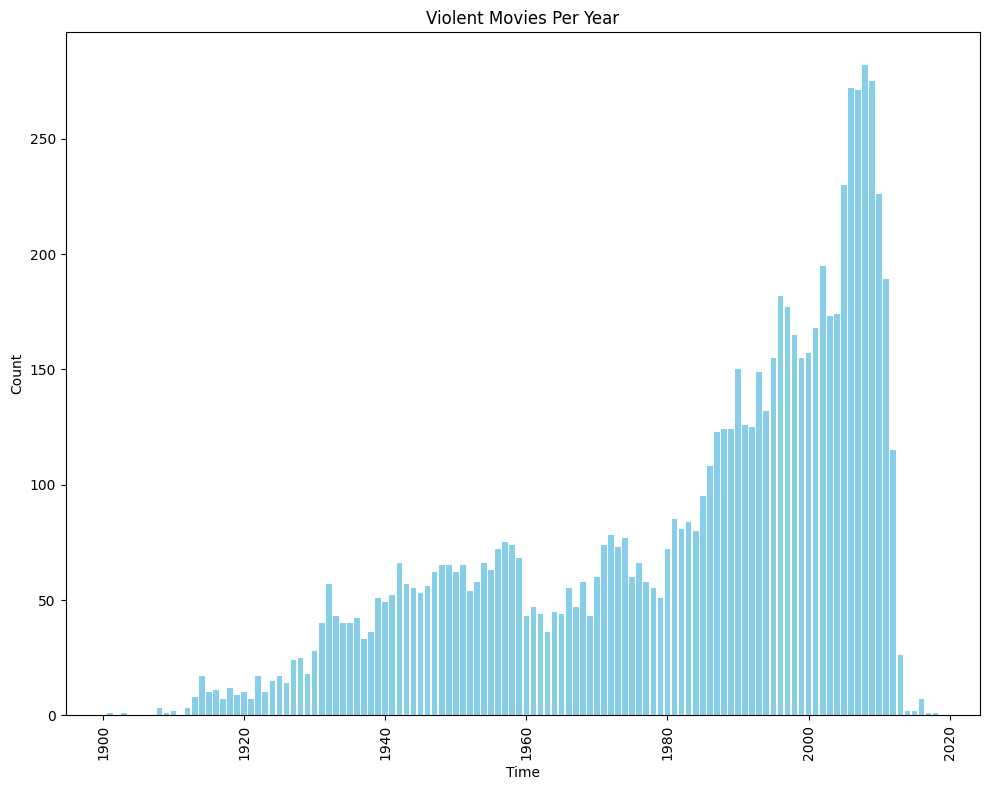

In [ ]:
plt.figure(figsize=(10, 8))
plt.bar(
    violent_movies_by_YEAR['Year'],  # X-axis: Date labels (Year-Week)
    violent_movies_by_YEAR['Count'],     # Y-axis: Count of events
    color='skyblue'
)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Violent Movies Per Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

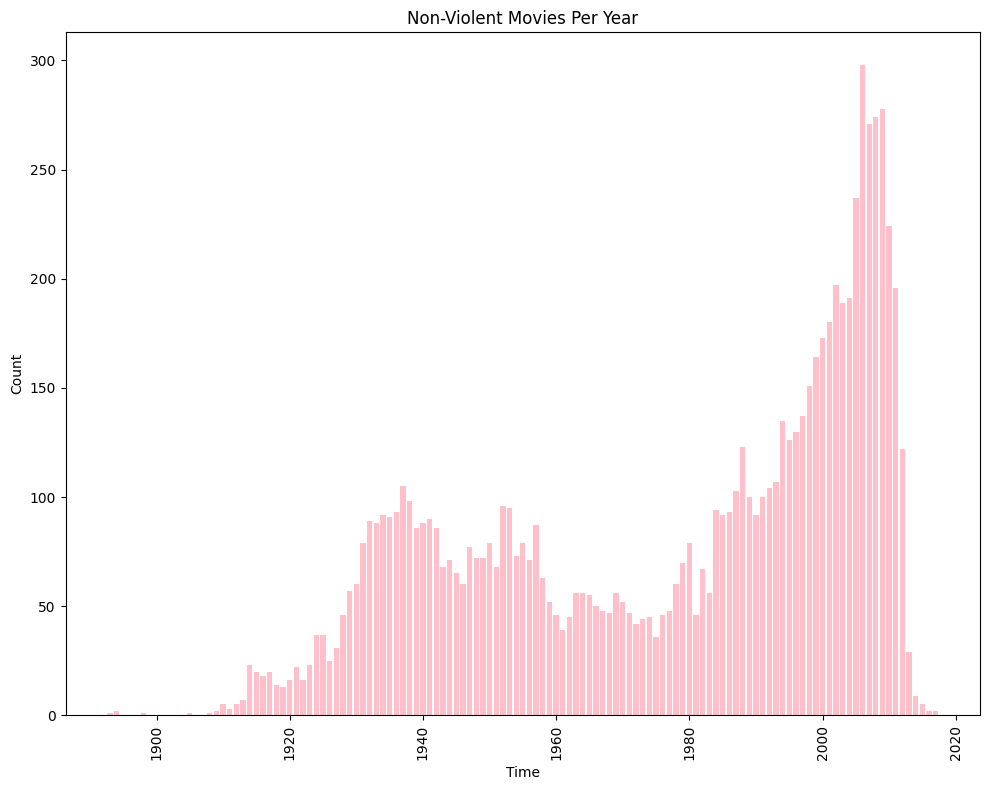

In [ ]:
Violent_Movies_autoregressive_discarded_by_YEAR = Violent_Movies_autoregressive_discarded.groupby(['Year']).size().reset_index(name='Count')
Violent_Movies_autoregressive_discarded_by_YEAR.sort_values(by=['Year'])
Violent_Movies_autoregressive_discarded_by_YEAR

plt.figure(figsize=(10, 8))
plt.bar(
    Violent_Movies_autoregressive_discarded_by_YEAR['Year'],  # X-axis: Date labels (Year-Week)
    Violent_Movies_autoregressive_discarded_by_YEAR['Count'],     # Y-axis: Count of events
    color='pink'
)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Non-Violent Movies Per Year')
plt.xticks(rotation=90)  # Rotate x-axis labels for better readability
plt.tight_layout()
plt.show()

In [ ]:
all_movies = Movie_Data_autoregressive.merge(LLM_binary_df, how='left', on='Wikipedia movie ID')
all_movies

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week,Result,Prediction
0,975900,Ghosts of Mars,2001-08-24,14010832.0,2001,34,Violent,1.0
1,6631279,Little city,1997-04-04,NaN,1997,14,Non-violent,-1.0
2,77856,Mary Poppins,1964-08-27,102272727.0,1964,35,Non-violent,-1.0
3,21926710,White on Rice,2009-05-31,NaN,2009,22,Non-violent,-1.0
4,156558,Baby Boy,2001-06-27,29381649.0,2001,26,Violent,1.0
...,...,...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,2005,10,Violent,1.0
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,1990,17,Violent,1.0
17074,1918494,State and Main,2000-08-26,6944471.0,2000,34,Non-violent,-1.0
17075,664006,Guilty as Sin,1993-06-04,22886222.0,1993,22,Violent,1.0


In [ ]:
all_movies = all_movies.groupby(['Year']).size().reset_index(name='Count')
all_movies.sort_values(by=['Year'])

plt.figure(figsize=(10, 8))
plt.bar(
    Violent_Movies_autoregressive_discarded_by_YEAR['Year'],
    Violent_Movies_autoregressive_discarded_by_YEAR['Count'], 
    color='pink'
)
plt.xlabel('Time')
plt.ylabel('Count')
plt.title('Non-Violent Movies Per Year')
plt.xticks(rotation=90) 
plt.tight_layout()
plt.show()

In [ ]:
grouped = all_movies.groupby(['Year', 'Result']).size().unstack(fill_value=0)
grouped["Total"] = grouped["Non-violent"] + grouped["Violent"]
grouped["Violent-ratio"] = grouped["Violent"]/grouped["Total"]
grouped

Result,Non-violent,Violent,Total,Violent-ratio
Year,,,,
1893,1,0,1,0.000000
1894,2,0,2,0.000000
1898,1,0,1,0.000000
1901,0,1,1,1.000000
1903,0,1,1,1.000000
...,...,...,...,...
2014,9,2,11,0.181818
2015,5,2,7,0.285714
2016,2,7,9,0.777778


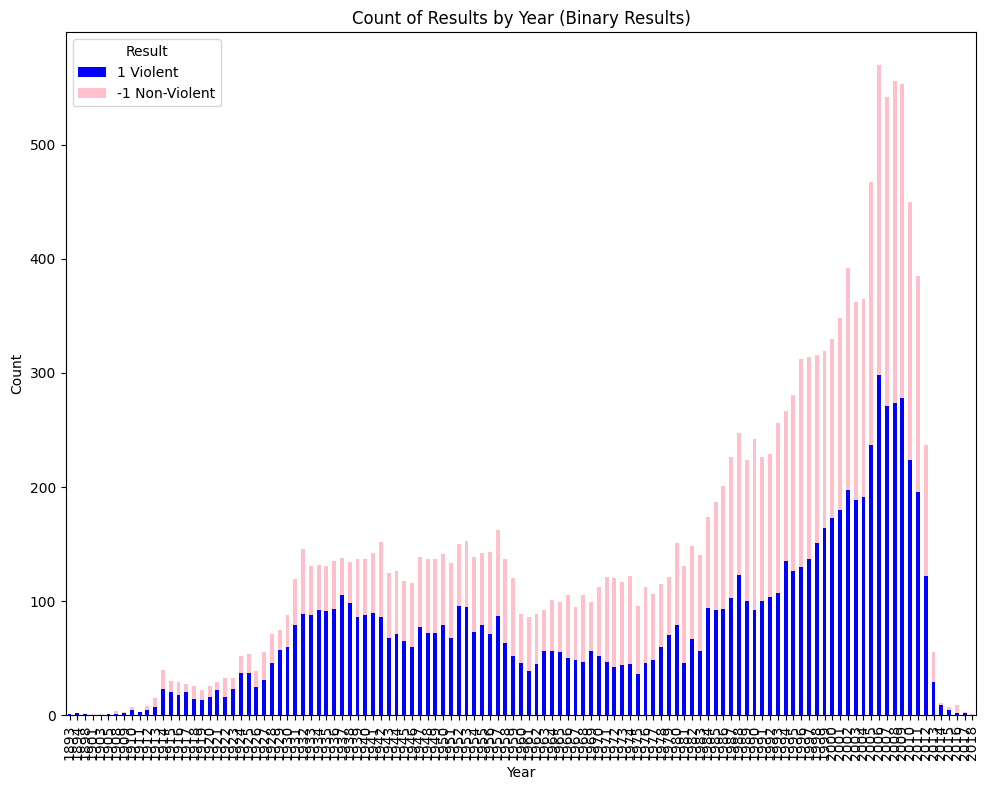

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
grouped[["Non-violent", "Violent"]].plot(kind='bar', stacked=True, color=['blue', 'pink'], ax=ax)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Results by Year (Binary Results)')
plt.xticks(rotation=90)
plt.legend(title='Result', labels=['1 Violent', '-1 Non-Violent'])
plt.tight_layout()
plt.show()

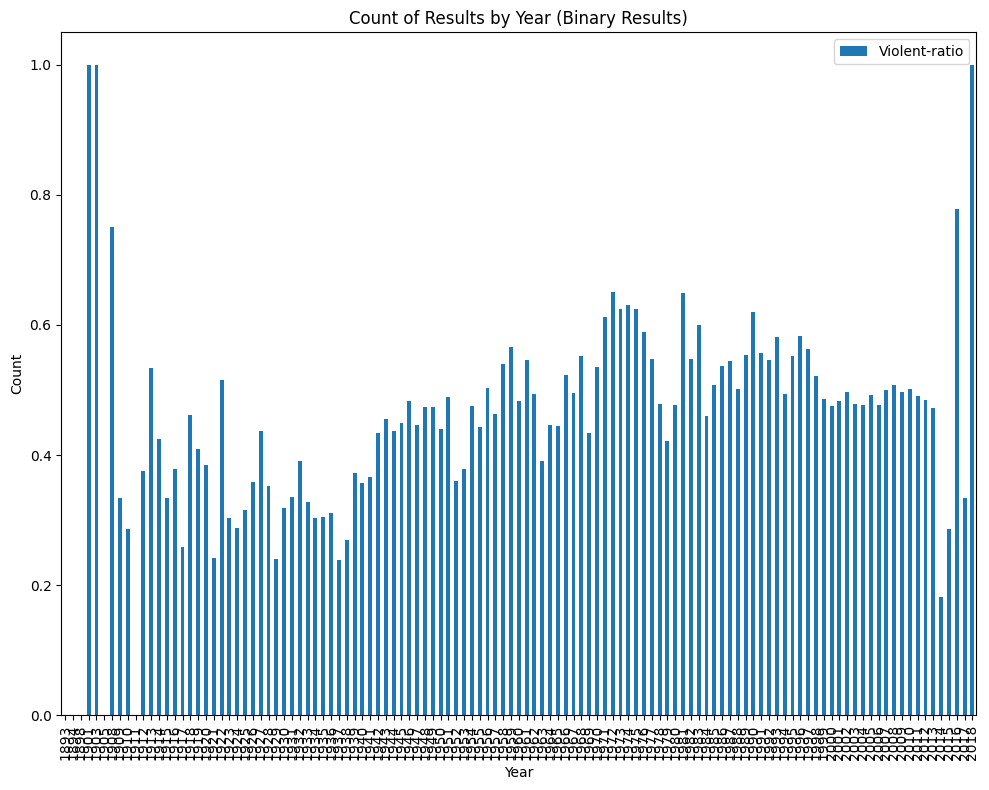

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
grouped[["Violent-ratio"]].plot(kind='bar', ax=ax)
plt.xlabel('Year')
plt.ylabel('Count')
plt.title('Count of Results by Year (Binary Results)')
plt.xticks(rotation=90)
plt.legend(labels=["Violent-ratio"])
plt.tight_layout()
plt.show()

## DataStory to copypaste in the Website

Do we blindly trust this classification? No, not really. \
We want to make sure that movies labelled as violent do indeed show violent content. Therefore, we choose to dive deeper into the categories most represented in the movies of the two groups (violent or non-violent). \
Before that, a quick glimpse at how the categories are distributed through the entire dataset (17'077 movies). First, we can look at which categories apprear most (_and here we would add the plot with the count for all categories_) and then do a Principal Component Analysis (PCA) in order to see if clusters of movies sharing the same main subject already appear in 2D. \
We clearly do see some clustering! \
Indeed, there is a net separation between _family_ movies and _kill_ movies. Moreover, we notive that _home, party_ and _children_ movies are closer to _family_ movies. They then start to blend, and we see that we transition from _negative emotion_ films to _kill_ very quickly. \
What do we expect then? We expect to have a good distinction between the topics appearing most in violent films versus non-violent ones. With maybe some unexpected behavior from Disney movies which, seeing the PCA, might not be as innocent as we think them to be.

## DATASET POUR JEN

In [101]:
Movie_Data_autoregressive

,Wikipedia movie ID,Movie name,Release date,Box office revenue,Year,Week
0,975900,Ghosts of Mars,2001-08-24,14010832.0,2001,34
1,6631279,Little city,1997-04-04,NaN,1997,14
2,77856,Mary Poppins,1964-08-27,102272727.0,1964,35
3,21926710,White on Rice,2009-05-31,NaN,2009,22
4,156558,Baby Boy,2001-06-27,29381649.0,2001,26
...,...,...,...,...,...,...
17072,25011340,Dot.Kill,2005-03-08,NaN,2005,10
17073,7761830,Spaced Invaders,1990-04-27,15369573.0,1990,17
17074,1918494,State and Main,2000-08-26,6944471.0,2000,34
17075,664006,Guilty as Sin,1993-06-04,22886222.0,1993,22


In [102]:
top_categories = empath_df.sum(axis=0).sort_values(ascending=False).head(10).index
top_categories

Index(['family', 'children', 'crime', 'death', 'wedding', 'home', 'party',
       'negative_emotion', 'traveling', 'kill'],
      dtype='object')

In [103]:
empath_df

,help,office,dance,money,wedding,domestic_work,sleep,medical_emergency,cold,hate,...,weapon,children,monster,ocean,giving,contentment,writing,rural,positive_emotion,musical
Wikipedia movie ID,,,,,,,,,,,,,,,,,,,,,
975900,0.000000,0.000000,0.000000,0.000000,0.000000,0.005236,0.005236,0.005236,0.000000,0.015707,...,0.020942,0.005236,0.000000,0.000000,0.020942,0.000000,0.000000,0.000000,0.005236,0.000000
6631279,0.009615,0.000000,0.000000,0.000000,0.038462,0.009615,0.009615,0.009615,0.009615,0.000000,...,0.000000,0.038462,0.000000,0.000000,0.019231,0.009615,0.000000,0.000000,0.019231,0.009615
77856,0.005305,0.002653,0.007958,0.047745,0.009284,0.025199,0.005305,0.003979,0.007958,0.002653,...,0.003979,0.053050,0.002653,0.001326,0.025199,0.000000,0.007958,0.003979,0.017241,0.010610
21926710,0.016129,0.000000,0.000000,0.000000,0.048387,0.016129,0.016129,0.000000,0.000000,0.000000,...,0.000000,0.080645,0.000000,0.000000,0.000000,0.000000,0.000000,0.016129,0.064516,0.000000
156558,0.016667,0.010000,0.000000,0.010000,0.050000,0.020000,0.000000,0.003333,0.006667,0.020000,...,0.023333,0.093333,0.003333,0.000000,0.006667,0.003333,0.000000,0.016667,0.016667,0.003333
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
25011340,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.037037,0.000000,0.000000
7761830,0.019048,0.006349,0.003175,0.000000,0.003175,0.003175,0.003175,0.003175,0.003175,0.012698,...,0.012698,0.012698,0.015873,0.038095,0.009524,0.000000,0.000000,0.009524,0.003175,0.003175
1918494,0.007812,0.007812,0.000000,0.031250,0.000000,0.000000,0.000000,0.015625,0.000000,0.007812,...,0.007812,0.015625,0.000000,0.000000,0.015625,0.007812,0.007812,0.007812,0.015625,0.015625


In [104]:
dominant_category = pd.DataFrame(empath_df[top_categories].idxmax(axis=1))
dominant_category.columns = ["Dominant_category"]
dominant_category.reset_index(inplace=True)
dominant_category

,Wikipedia movie ID,Dominant_category
0,975900,kill
1,6631279,negative_emotion
2,77856,family
3,21926710,family
4,156558,children
...,...,...
17072,25011340,crime
17073,7761830,kill
17074,1918494,children
17075,664006,crime


In [108]:
All_Movies_Classified_Jen = Movie_Data_autoregressive.merge(dominant_category, how='left', on='Wikipedia movie ID')
All_Movies_Classified_Jen.to_csv('../data/CLEAN/All_Movies_Classified_Jen.tsv', sep="\t")